## Coronavirus Prediction using SVM

Address the following questions:

- What the problem is about?
- What prior knowledge the agent has, which influences the model it builds?
- What data and feedback on the data is available?
- What is the size of the data?
- How to load a dataset that has non-numbers?
- What are the features (predictors and target variable) in the data?
- Are there any missing data? If so, how to handle them?
- what the data is saying?
- what kind of model(learning agent) is suited for the data?
- are all predictors necessary for the agent?


## Import Libraries


In [1]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

try:
    # for visual mode. `pip install -e .[visual]`
    import matplotlib.pyplot as plt
    import matplotlib
    %matplotlib inline
    import seaborn as sns
except ModuleNotFoundError:
    plt = None
    sns = None

## Define Constants

In [2]:
TARGET_LABEL = 'Corona'

## DataFrame Display Function

In [3]:
def display_df(df:pd.DataFrame, show_missing:bool=True, show_info:bool=False) -> None:
    """Display the DataFrame.
    
    :param df: The data.
    :type df: pd.DataFrame
    :param show_missing: Whether to show missing data counts.
    :type show_missing: bool
    :param show_info: Whether to show info on the data.
    :type show_info: bool
    """
    print(f'DataFrame shape: {df.shape}')
    print(f'First 5 rows:\n{df.head()}') # preview the first 5 rows
    if show_missing:
        # find any non-numeric data
        print(f'Missing values:\n{df.isna().sum()}')
    if show_info:
        print(f'Info:\n{df.info()}')

## Dataset Cleanup
- Remove rows:
    - missing any of the symptoms.
    - diagnosis of 'other'

In [4]:
def data_disposal(df:pd.DataFrame) -> pd.DataFrame:
    """Clean-up the DataFrame.

    Remove rows:
        - missing any of the symptoms
        - diagnosis of 'other'
    
    :param df: The data.
    :type df: pd.DataFrame
    :return: The data without disposals.
    :rtype: pd.DataFrame
    """
    # remove rows missing too many values
    required_fields=[TARGET_LABEL, 'Cough_symptoms', 'Fever', 'Sore_throat', 'Shortness_of_breath', 'Headache']
    print(f'Dropping the rows missing required columns: {required_fields}')
    df = df.dropna(subset=required_fields)
    # weird find, get rid of rows where diagnosis is 'other'
    df = df[df[TARGET_LABEL] != 'other']
    return df

## Datatype Conversions
- Convert bools to `0|1`.
- Fill nulls for typically-binary variables with 0.5.
- Scale 'Known_contact' with best-guess weights. Could use SA to fine-tune.
- convert 'Test_date' to unix epoch

In [5]:
def data_conversions(df:pd.DataFrame) -> pd.DataFrame:
    """Convert type in the DataFrame.

    Update values:
        - Convert bools to `0|1`.
        - Fill nulls for typically-binary variables with 0.5.
        - Scale 'Known_contact' with best-guess weights. Could use SA to fine-tune.
        - convert 'Test_date' to unix epoch

    :param df: The data.
    :type df: pd.DataFrame
    :return: The data without conversions.
    :rtype: pd.DataFrame
    """
    # check for "weird" data
    weird_check_cols = ['Test_date', TARGET_LABEL, 'Age_60_above', 'Sex', 'Known_contact']
    for col in weird_check_cols:
        print(f'Column "{col}" distinct values:\t{df[col].unique()}')
    # filter bools
    df = df.replace(to_replace={
        False: 0, True: 1,
        'negative': 0, 'positive': 1,
        'No': 0, 'Yes': 1,
        'male': 0, 'female': 1
    })
    # weird finds, fill null values for typically-binary variables with 0.5
    df = df.fillna({
        'Age_60_above': 0.5,
        'Sex': 0.5
    })
    # weird find, scale 'Known_contact' with best-guess weights. Could use SA to fine-tune.
    df = df.replace(to_replace={'Known_contact': {'Abroad': 1, 'Contact with confirmed': 0.6, 'Other': 0}})
    # last weird find, convert 'Test_date' to unix epoch
    df['Test_date'] = pd.to_datetime(df['Test_date'], format='%d-%m-%Y').astype('int64') / 10**9
    # finally infer objects
    return df.infer_objects()

## Open the Dataset File

Upon first loading the dataset, this warning is output:

```
DtypeWarning: Columns (2,3,4,5,6,8) have mixed types. Specify dtype option on import or set low_memory=False.
```
Which means we'll have 6 columns to clean up.


In [6]:
pd.set_option('mode.copy_on_write', True)
pd.set_option('future.no_silent_downcasting', True)
try:
    df = pd.read_csv('./corona-1.csv')
except FileNotFoundError:
    print(f'Could not open file for read: {dataset_filename}')
display_df(df)

DataFrame shape: (278848, 11)
First 5 rows:
   Ind_ID   Test_date Cough_symptoms  Fever Sore_throat Shortness_of_breath  \
0       1  11-03-2020           True  False        True               False   
1       2  11-03-2020          False   True       False               False   
2       3  11-03-2020          False   True       False               False   
3       4  11-03-2020           True  False       False               False   
4       5  11-03-2020           True  False       False               False   

  Headache    Corona Age_60_above  Sex           Known_contact  
0    False  negative          NaN  NaN                  Abroad  
1    False  positive          NaN  NaN                  Abroad  
2    False  positive          NaN  NaN                  Abroad  
3    False  negative          NaN  NaN                  Abroad  
4    False  negative          NaN  NaN  Contact with confirmed  
Missing values:
Ind_ID                      0
Test_date                   0
Cough_symptoms 

C:\Users\ahest\AppData\Local\Temp\ipykernel_19816\2247866662.py:4: DtypeWarning: Columns (2,3,4,5,6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./corona-1.csv')


## Remove Bad Data
- Remove data:
    - missing any of the symptoms.
    - diagnosis of 'other'


In [7]:
# Remove bad data
df = data_disposal(df)
display_df(df)

Dropping the rows missing required columns: ['Corona', 'Cough_symptoms', 'Fever', 'Sore_throat', 'Shortness_of_breath', 'Headache']
DataFrame shape: (274702, 11)
First 5 rows:
   Ind_ID   Test_date Cough_symptoms  Fever Sore_throat Shortness_of_breath  \
0       1  11-03-2020           True  False        True               False   
1       2  11-03-2020          False   True       False               False   
2       3  11-03-2020          False   True       False               False   
3       4  11-03-2020           True  False       False               False   
4       5  11-03-2020           True  False       False               False   

  Headache    Corona Age_60_above  Sex           Known_contact  
0    False  negative          NaN  NaN                  Abroad  
1    False  positive          NaN  NaN                  Abroad  
2    False  positive          NaN  NaN                  Abroad  
3    False  negative          NaN  NaN                  Abroad  
4    False  negative    

## Numerify Remaining Data
- Convert bools to `0|1`.
- Fill nulls for typically-binary variables with 0.5.
- Scale 'Known_contact' with best-guess weights. Could use SA to fine-tune.
- convert 'Test_date' to unix epoch

In [8]:
# Numerify some data
df = data_conversions(df)
display_df(df)

Column "Test_date" distinct values:	['11-03-2020' '12-03-2020' '13-03-2020' '14-03-2020' '15-03-2020'
 '16-03-2020' '17-03-2020' '18-03-2020' '19-03-2020' '20-03-2020'
 '21-03-2020' '22-03-2020' '23-03-2020' '24-03-2020' '25-03-2020'
 '26-03-2020' '27-03-2020' '28-03-2020' '29-03-2020' '30-03-2020'
 '31-03-2020' '01-04-2020' '02-04-2020' '03-04-2020' '04-04-2020'
 '05-04-2020' '06-04-2020' '07-04-2020' '08-04-2020' '09-04-2020'
 '10-04-2020' '11-04-2020' '12-04-2020' '13-04-2020' '14-04-2020'
 '15-04-2020' '16-04-2020' '17-04-2020' '18-04-2020' '19-04-2020'
 '20-04-2020' '21-04-2020' '22-04-2020' '23-04-2020' '24-04-2020'
 '25-04-2020' '26-04-2020' '27-04-2020' '28-04-2020' '29-04-2020'
 '30-04-2020']
Column "Corona" distinct values:	['negative' 'positive']
Column "Age_60_above" distinct values:	[nan 'No' 'Yes']
Column "Sex" distinct values:	[nan 'male' 'female']
Column "Known_contact" distinct values:	['Abroad' 'Contact with confirmed' 'Other']
DataFrame shape: (274702, 11)
First 5 ro

## Shuffle the Rows

When you shuffle rows, there's a trade-off.

- Better prepared for unseen data.
- Lose reproducibility of model-training.

In [9]:
df = df.sample(frac=1)
display_df(df, show_info=True)

DataFrame shape: (274702, 11)
First 5 rows:
        Ind_ID     Test_date  Cough_symptoms  Fever  Sore_throat  \
147001  147002  1.586736e+09               0      0            0   
273372  273373  1.588205e+09               0      0            0   
26349    26350  1.585094e+09               0      0            0   
47532    47533  1.585354e+09               0      0            0   
117580  117581  1.586304e+09               0      0            0   

        Shortness_of_breath  Headache  Corona  Age_60_above  Sex  \
147001                    0         0       0           0.0  0.0   
273372                    0         0       0           0.5  1.0   
26349                     0         0       0           0.0  0.0   
47532                     0         0       0           1.0  0.0   
117580                    0         0       0           0.0  1.0   

        Known_contact  
147001            0.0  
273372            0.0  
26349             0.0  
47532             0.0  
117580            

## Split into Training/Validation Sets


In [10]:
# Split into Training/Validation sets
X = df.drop([TARGET_LABEL], axis=1)
y = df[TARGET_LABEL]
# drop id. it would poison the data.
X = X.drop(['Ind_ID'], axis=1)
# after some thought, I will remove the 'Test_date' from training set.
X = X.drop(['Test_date'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')

X_train: (219761, 8)
X_test: (54941, 8)


## Show the Heatmap

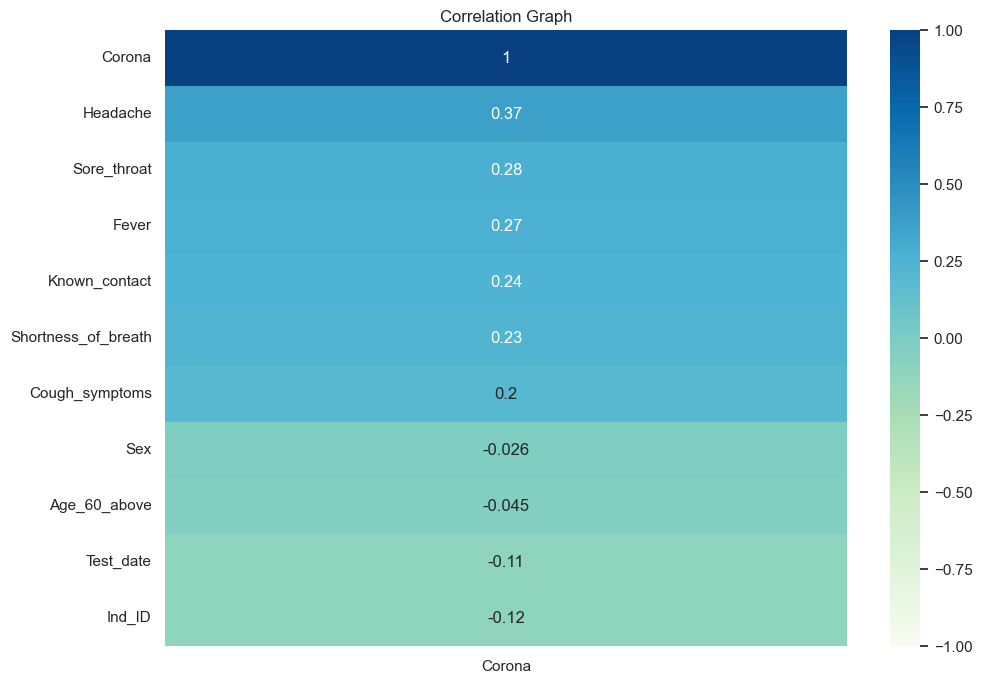

In [11]:
if plt is not None:
    sns.set()
    plt.figure(figsize = (11,8))
    plt.title('Correlation Graph')
    # Plotting the heatmap to check the correlation between the Target Label and other features
    sns.heatmap(df.corr()[[TARGET_LABEL]].sort_values(by=TARGET_LABEL, ascending=False), vmin=-1, vmax=1, annot=True, cmap='GnBu')
    plt.show()

## Create and Train the Model
This takes a couple minutes.

In [12]:
# create and train the model
model = SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(kernel='linear')

## Use the Model to Predict
- on the Training set.
- and the Test set.

In [13]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

## Round-up Scores

In [14]:
scores = {
    'accuracy': {'train': accuracy_score(y_train, train_preds), 'test': accuracy_score(y_test, test_preds)},
    'precision': {'train': precision_score(y_train, train_preds), 'test': precision_score(y_test, test_preds)},
    'recall': {'train': recall_score(y_train, train_preds), 'test': recall_score(y_test, test_preds)},
    'f1-score': {'train': f1_score(y_train, train_preds), 'test': f1_score(y_test, test_preds)},
}
print(scores)
print(y_test.head())
print(test_preds[0:5])
scores_df = pd.DataFrame(scores)
print(scores_df)

{'accuracy': {'train': 0.9576130432606331, 'test': 0.9569356218488925}, 'precision': {'train': 0.8336974330966684, 'test': 0.8236632536973834}, 'recall': {'train': 0.2596309209966834, 'test': 0.24667802385008517}, 'f1-score': {'train': 0.3959535698074055, 'test': 0.37965390665967486}}
113395    0
89804     1
182226    0
51420     0
257983    0
Name: Corona, dtype: int64
[0 0 0 0 0]
       accuracy  precision    recall  f1-score
train  0.957613   0.833697  0.259631  0.395954
test   0.956936   0.823663  0.246678  0.379654


## Questions
- What the problem is about?
    - Binary classification of the coronavirus based on a kaggle dataset.
- What prior knowledge the agent has, which influences the model it builds?
    - None.
- What data and feedback on the data is available?
    - Symptoms, age, sex, diagnosis
- What is the size of the data?
    - (278848, 11)
- How to load a dataset that has non-numbers?
    - Handled in section #Numerify Remaining Data above.
- What are the features (predictors and target variable) in the data?
    - Predictors: symptoms
    - Target: diagnosis
- Are there any missing data? If so, how to handle them?
    - Yes. Handled in #Remove Bad Data and #Numerify Remaining Data above.
- what the data is saying?
    - Shown by the heatmap.
- what kind of model(learning agent) is suited for the data?
    - Possibly a deep learning model would fit such messy data better.
- are all predictors necessary for the agent?
    - No, but we'll take what we can get.
